In [20]:
import tensorflow as tf
import PIL
from PIL import Image
from scipy.misc import imread, imshow,imresize
from glob import glob
from itertools import cycle,zip_longest
import numpy as np
import matplotlib.pyplot as plt
import imageio
import random
import os
from tensorflow.contrib import slim
import time
import sys
sys.path.insert(0, '/home/ubuntu/workspace/models/research/slim/')
from nets.resnet_v1 import resnet_v1,resnet_v1_101,resnet_arg_scope
from preprocessing import inception_preprocessing, vgg_preprocessing
from datasets import dataset_utils

In [ ]:
url = "http://download.tensorflow.org/models/resnet_v1_101_2016_08_28.tar.gz"

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

In [21]:
random.seed(42)
tf.set_random_seed(42)
def grouper(n, iterable, fillvalue=None):
  args = [iter(iterable)]*n
  return zip_longest(*args, fillvalue=fillvalue)
height_image = resnet_v1.default_image_size
width_image = resnet_v1.default_image_size
print(height_image)
data_dir = "/home/ubuntu/project/data/"
checkpoints_dir = '/tmp/checkpoints'

224


In [22]:
def get_images(data_dir, data_type, batch_size=10):
  height = height_image
  width = width_image
  if(data_type == 1):
    data_dir = data_dir +"Train/"
  elif(data_type == 2):
    data_dir = data_dir +"Val/"
  elif(data_type == 3):
    data_dir = data_dir +"Test/"
  input_files_positive = glob(data_dir + "Positive/*.jpg")
  input_files_negative = glob(data_dir + "Negative/*.jpg")
  input_files_neutral = glob(data_dir + "Neutral/*.jpg")
  #input_files_positive = glob(data_dir + "daisy/*.jpg")
  #input_files_negative = glob(data_dir + "roses/*.jpg")
  #input_files_neutral = glob(data_dir + "tulips/*.jpg")
  input_files = input_files_positive + input_files_negative + input_files_neutral
  labels = [np.array([0,0,1])]*len(input_files_positive) + [np.array([0,1,0])]*len(input_files_negative) + [np.array([1,0,0])]*len(input_files_neutral)
  label_files = list(zip(input_files,labels))
  label_files = random.sample(label_files,len(label_files))
  label_files_infinite = cycle(label_files)

  label_files_grouped = grouper(batch_size,label_files_infinite)
  while 1:
    image_names,labels = zip(*next(label_files_grouped))
    
    dx = height_image
    dy = width_image
    
    image_data = [Image.open(fname) for fname in image_names]
    
    if(data_type == 1):
        resized_small = [image.resize((256,256),PIL.Image.ANTIALIAS) if (image.size[0] < 256 or image.size[1] < 256) else image for image in image_data]
        #images = [image.resize((256,256),PIL.Image.ANTIALIAS) for image in image_data]
        images = [image.resize((356,356),PIL.Image.ANTIALIAS) if (image.size[0] > 300 or image.size[1] > 300) else image for image in resized_small]
    
        images_crop = []
        for image in images:
            x = random.randint(0, image.size[0]-dx-1)
            y = random.randint(0, image.size[1]-dy-1) 
            images_crop.append(image.crop((x,y, x+dx, y+dy)))
    
        flipped_images = [np.fliplr(image) if np.random.random() > 0.5 else image for image in images_crop]
        pil_images = []
        for i in range(len(flipped_images)):
            gauss = 0
            gauss = np.random.normal(0,0.1**0.5,(width_image,height_image,3))
            flipped_images[i] = flipped_images[i] + gauss.reshape(width_image,height_image,3)*50
            pil_images.append((flipped_images[i] - flipped_images[i].min())/(flipped_images[i].max()-flipped_images[i].min()))
    elif(data_type == 2):
        pil_images = [image.resize((dx,dy),PIL.Image.ANTIALIAS)  for image in image_data]
    
    image_files = [np.array(np_image) for np_image in pil_images]
    
    yield zip(image_files,list(labels))


In [18]:
a = get_images(data_dir,1,15)

3
15


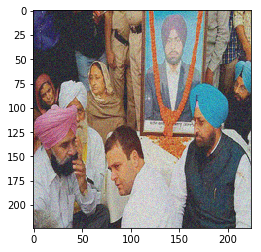

In [19]:
images, labels = map(list, zip(*next(a)))
print(labels[0].size)
print(len(images))
plt.imshow(images[0])
plt.show()


In [23]:
#total input dataset
total_num_images_training = 3630
total_num_images_validation = 2065

#data segmentation
num_epochs = 20 #hp 1
batch_size = 50 #hp 2

#learning rate
initial_learning_rate = 0.001 #hp 3
num_epochs_before_decay = 25
learning_rate_decay_iterations = 15 #hp 4

#dropout
keep_prob_val = 0.9 #hp 5
keep_prob_val_data = 0.9 #hp 5

#size of each training/validation iteration
num_batches_per_epoch_training = int(total_num_images_training / batch_size)
num_batches_per_epoch_validaton = int(total_num_images_validation / batch_size)

#data feeder generators
training_generator = get_images(data_dir,1,batch_size)
validation_generator = get_images(data_dir,2,batch_size)
test_generator = get_images(data_dir,2,batch_size)
def feed_dict(batch_size,generator, epoch, use_dropout):
    
    lr = initial_learning_rate

    keep_prob_per = 1
    keep_prob_data_per = 1

    if use_dropout == 1:
        keep_prob_per = keep_prob_val
        keep_prob_data_per = keep_prob_val_data

    imgs, lbls = map(list, zip(*next(generator)))

    if(epoch == 20):
        lr = 0.0001
    #elif(epoch == 7):
    #    lr = 0.001
    #elif(epoch >= num_epochs_before_decay)# and epoch % learning_rate_decay_iterations == 0):
        #lr = 0.
    #    lr = 0.001*(10**(-epoch/100))
        #lr = lr*0.1

    return {images: imgs, labels: lbls,learning_rate: lr, keep_prob: keep_prob_per, keep_prob_data: keep_prob_data_per}

In [24]:
tf.reset_default_graph()

images = tf.placeholder(tf.float32,shape=[None,height_image,width_image,3])
labels = tf.placeholder(tf.float32,shape=[None,3])
learning_rate = tf.placeholder(tf.float32,shape=[])
keep_prob = tf.placeholder(tf.float32,shape=[])
keep_prob_data = tf.placeholder(tf.float32,shape=[])

with slim.arg_scope(resnet_arg_scope()):
    logits_drop_1 = tf.contrib.layers.dropout(images, keep_prob_data)
    resnet_logits, end_points = resnet_v1_101(logits_drop_1, num_classes=3, global_pool=True, is_training=True)
    
checkpoint_exclude_scopes=["resnet_v1_101/logits"]
#checkpoint_exclude_scopes=[]
exclusions = checkpoint_exclude_scopes
#review code!
variables_to_restore = []
for var in slim.get_model_variables():
    excluded = False
    for exclusion in exclusions:
        if var.op.name.startswith(exclusion):
            excluded = True
            break
    if not excluded:
        variables_to_restore.append(var)
#variables_to_restore = slim.get_variables_to_restore(exclude = checkpoint_exclude_scopes)
saver = tf.train.Saver(variables_to_restore)

#final_shape = end_points['global_pool'].get_shape()
#flatten_size = int(final_shape[1]*final_shape[2]*final_shape[3])
#flatten = tf.reshape(end_points['global_pool'], [-1, flatten_size])
#introduce dropout for resnet final FC layer
#logits_drop = tf.contrib.layers.dropout(flatten, keep_prob)
#introduce final FC layer to map output of resnet 1000 to 3 classes
#logits = tf.contrib.layers.fully_connected(logits_drop, 3)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=resnet_logits))
correct_prediction = tf.equal(tf.argmax(resnet_logits,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
precision = tf.metrics.precision(tf.argmax(resnet_logits,1), tf.argmax(labels,1))
recall = tf.metrics.recall(tf.argmax(resnet_logits,1), tf.argmax(labels,1))
#f1_score = 2 ** (precision * recall/(precision + recall))
#f1_score = 1

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = slim.learning.create_train_op(cross_entropy, optimizer)


with tf.Session() as sess:
 
  saver.restore(sess,os.path.join(checkpoints_dir, 'resnet_v1_101.ckpt'))
  sess.run(tf.initialize_all_variables())
  sess.run(tf.global_variables_initializer())
  sess.run(tf.local_variables_initializer())
  
  total_loss_val = 0
  total_val_loss_val = 0
  total_train_accuracy = 0
  total_val_accuracy = 0
  best_accuracy = 0
  avg_training_acc = 0
  avg_val_acc = 0
  start_time_per_epoch = 0
  time_elapsed_eval_per_epoch = 0
  time_elapsed_training_per_epoch = 0
  overall_training_time = 0
  total_f1 = 0
  total_precision = 0
  total_recall = 0
  avg_precision = 0
  avg_recall = 0
  avg_fl = 0
  
  overall_training_time = time.time()
  for i in range(num_epochs):
    
    best_acc_file = open('/home/ubuntu/project/L44_Mini_Project/data_dir/resnet_accuracy/best_accuracy.txt',"a") 
    all_acc_file = open('/home/ubuntu/project/L44_Mini_Project/data_dir/resnet_accuracy/all_accuracy.txt',"a") 
    
    start_time_per_epoch = time.time()
    for j in range(num_batches_per_epoch_training):
      print("Epoch %s, Batch %s" % (i,j))
      _,training_loss = sess.run([train_op, cross_entropy],feed_dict=feed_dict(batch_size,training_generator,i,True))
      train_accuracy = accuracy.eval(feed_dict=feed_dict(batch_size,training_generator,i,True))
      total_loss_val = total_loss_val + training_loss
      total_train_accuracy = total_train_accuracy + train_accuracy
    avg_training_acc = total_train_accuracy/num_batches_per_epoch_training
    print("--------------------------------------------------------------------")
    print("Epoch %s: training accuracy %s, training loss %s" % (i,avg_training_acc,total_loss_val))
    time_elapsed_training_per_epoch = time.time() - start_time_per_epoch
    for _ in range(num_batches_per_epoch_validaton):
      validation_loss, precision_val, recall_val = sess.run([cross_entropy,precision,recall],feed_dict=feed_dict(batch_size,validation_generator,i,False))
      total_val_loss_val = total_val_loss_val + validation_loss
      validation_accuracy = accuracy.eval(feed_dict=feed_dict(batch_size,validation_generator,i,False))
      total_val_accuracy = total_val_accuracy + validation_accuracy
      total_precision = total_precision + precision_val[0]
      total_recall = total_recall + recall_val[0]
    avg_precision = total_precision/num_batches_per_epoch_validaton
    avg_recall = total_recall/num_batches_per_epoch_validaton
    avg_val_acc = total_val_accuracy/num_batches_per_epoch_validaton
    avg_fl = 2 * (avg_precision * avg_recall/(avg_precision + avg_recall))
    print("Epoch %s: validation accuracy %s, validation loss %s, fl score %s" % (i,avg_val_acc, total_val_loss_val, avg_fl))
    print("--------------------------------------------------------------------")
    time_elapsed_eval_per_epoch = time.time() - start_time_per_epoch - time_elapsed_training_per_epoch
    all_acc_file.write("%s %s %s %s %s %s %s %s %s %s\n" % (i, total_loss_val, total_val_loss_val, avg_training_acc, avg_val_acc, avg_fl, avg_precision, avg_recall, time_elapsed_training_per_epoch, time_elapsed_eval_per_epoch))
   
    #store model at best accuracy
    if avg_val_acc > best_accuracy:
      best_acc_file.write("Epoch %s: " % (i))
      best_acc_file.write("Best validation accuracy: %s\n" % (avg_val_acc))
      best_accuracy = avg_val_acc
      best_model_path = saver.save(sess, '/home/ubuntu/project/best_models/resnet/')  
    
    total_loss_val = 0
    total_val_loss_val = 0
    total_train_accuracy = 0
    total_val_accuracy = 0
    avg_training_acc = 0
    avg_val_acc = 0
    best_model_path = ""
    start_time = 0
    time_elapsed_eval = 0
    time_elapsed_training = 0
    avg_fl = 0
    total_f1 = 0
    total_precision = 0
    total_recall = 0
    avg_precision = 0
    avg_recall = 0
    
    best_acc_file.close()
    all_acc_file.close()
    
  overall_training_time = time.time() - overall_training_time
  print("Training time: %s" % overall_training_time)
    

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
INFO:tensorflow:Restoring parameters from /tmp/checkpoints/resnet_v1_101.ckpt
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch 0, Batch 0
Epoch 0, Batch 1
Epoch 0, Batch 2
Epoch 0, Batch 3
Epoch 0, Batch 4
Epoch 0, Batch 5
Epoch 0, Batch 6
Epoch 0, Batch 7
Epoch 0, Batch 8
Epoch 0, Batch 9
Epoch 0, Batch 10
Epoch 0, Batch 11
Epoch 0, Batch 12
Epoch 0, Batch 13
Epoch 0, Batch 14
Epoch 0, Batch 15
Epoch 0, Batch 16
Epoch 0, Batch 17
Epoch 0, Batch 18
Epoch 0, Batch 19
Epoch 0, Batch 20
Epoch 0, Batch 21
Epoch 0, Batch 22
Epoch 0, Batch 23
Epoch 0, Batch 24
Epoch 0, Batch 25


/home/ubuntu/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 0, Batch 26
Epoch 0, Batch 27
Epoch 0, Batch 28
Epoch 0, Batch 29
Epoch 0, Batch 30
Epoch 0, Batch 31
Epoch 0, Batch 32
Epoch 0, Batch 33
Epoch 0, Batch 34
Epoch 0, Batch 35
Epoch 0, Batch 36
Epoch 0, Batch 37
Epoch 0, Batch 38
Epoch 0, Batch 39
Epoch 0, Batch 40
Epoch 0, Batch 41
Epoch 0, Batch 42
Epoch 0, Batch 43
Epoch 0, Batch 44
Epoch 0, Batch 45
Epoch 0, Batch 46
Epoch 0, Batch 47
Epoch 0, Batch 48
Epoch 0, Batch 49
Epoch 0, Batch 50
Epoch 0, Batch 51
Epoch 0, Batch 52
Epoch 0, Batch 53
Epoch 0, Batch 54
Epoch 0, Batch 55
Epoch 0, Batch 56
Epoch 0, Batch 57
Epoch 0, Batch 58
Epoch 0, Batch 59
Epoch 0, Batch 60
Epoch 0, Batch 61
Epoch 0, Batch 62
Epoch 0, Batch 63
Epoch 0, Batch 64
Epoch 0, Batch 65
Epoch 0, Batch 66
Epoch 0, Batch 67
Epoch 0, Batch 68
Epoch 0, Batch 69
Epoch 0, Batch 70
Epoch 0, Batch 71
--------------------------------------------------------------------
Epoch 0: training accuracy 0.3919444436000453, training loss 102.21002471446991
Epoch 0: validation acc

Epoch 5, Batch 33
Epoch 5, Batch 34
Epoch 5, Batch 35
Epoch 5, Batch 36
Epoch 5, Batch 37
Epoch 5, Batch 38
Epoch 5, Batch 39
Epoch 5, Batch 40
Epoch 5, Batch 41
Epoch 5, Batch 42
Epoch 5, Batch 43
Epoch 5, Batch 44
Epoch 5, Batch 45
Epoch 5, Batch 46
Epoch 5, Batch 47
Epoch 5, Batch 48
Epoch 5, Batch 49
Epoch 5, Batch 50
Epoch 5, Batch 51
Epoch 5, Batch 52
Epoch 5, Batch 53
Epoch 5, Batch 54
Epoch 5, Batch 55
Epoch 5, Batch 56
Epoch 5, Batch 57
Epoch 5, Batch 58
Epoch 5, Batch 59
Epoch 5, Batch 60
Epoch 5, Batch 61
Epoch 5, Batch 62
Epoch 5, Batch 63
Epoch 5, Batch 64
Epoch 5, Batch 65
Epoch 5, Batch 66
Epoch 5, Batch 67
Epoch 5, Batch 68
Epoch 5, Batch 69
Epoch 5, Batch 70
Epoch 5, Batch 71
--------------------------------------------------------------------
Epoch 5: training accuracy 0.4794444433516926, training loss 77.17632734775543
Epoch 5: validation accuracy 0.45999999889513343, validation loss 44.010600209236145, fl score 0.6847551659792048
------------------------------------

Epoch 10, Batch 38
Epoch 10, Batch 39
Epoch 10, Batch 40
Epoch 10, Batch 41
Epoch 10, Batch 42
Epoch 10, Batch 43
Epoch 10, Batch 44
Epoch 10, Batch 45
Epoch 10, Batch 46
Epoch 10, Batch 47
Epoch 10, Batch 48
Epoch 10, Batch 49
Epoch 10, Batch 50
Epoch 10, Batch 51
Epoch 10, Batch 52
Epoch 10, Batch 53
Epoch 10, Batch 54
Epoch 10, Batch 55
Epoch 10, Batch 56
Epoch 10, Batch 57
Epoch 10, Batch 58
Epoch 10, Batch 59
Epoch 10, Batch 60
Epoch 10, Batch 61
Epoch 10, Batch 62
Epoch 10, Batch 63
Epoch 10, Batch 64
Epoch 10, Batch 65
Epoch 10, Batch 66
Epoch 10, Batch 67
Epoch 10, Batch 68
Epoch 10, Batch 69
Epoch 10, Batch 70
Epoch 10, Batch 71
--------------------------------------------------------------------
Epoch 10: training accuracy 0.5180555577907298, training loss 72.51501727104187
Epoch 10: validation accuracy 0.4721951223001247, validation loss 40.80610680580139, fl score 0.7039459743889694
--------------------------------------------------------------------
Epoch 11, Batch 0
Epoch

Epoch 15, Batch 25
Epoch 15, Batch 26
Epoch 15, Batch 27
Epoch 15, Batch 28
Epoch 15, Batch 29
Epoch 15, Batch 30
Epoch 15, Batch 31
Epoch 15, Batch 32
Epoch 15, Batch 33
Epoch 15, Batch 34
Epoch 15, Batch 35
Epoch 15, Batch 36
Epoch 15, Batch 37
Epoch 15, Batch 38
Epoch 15, Batch 39
Epoch 15, Batch 40
Epoch 15, Batch 41
Epoch 15, Batch 42
Epoch 15, Batch 43
Epoch 15, Batch 44
Epoch 15, Batch 45
Epoch 15, Batch 46
Epoch 15, Batch 47
Epoch 15, Batch 48
Epoch 15, Batch 49
Epoch 15, Batch 50
Epoch 15, Batch 51
Epoch 15, Batch 52
Epoch 15, Batch 53
Epoch 15, Batch 54
Epoch 15, Batch 55
Epoch 15, Batch 56
Epoch 15, Batch 57
Epoch 15, Batch 58
Epoch 15, Batch 59
Epoch 15, Batch 60
Epoch 15, Batch 61
Epoch 15, Batch 62
Epoch 15, Batch 63
Epoch 15, Batch 64
Epoch 15, Batch 65
Epoch 15, Batch 66
Epoch 15, Batch 67
Epoch 15, Batch 68
Epoch 15, Batch 69
Epoch 15, Batch 70
Epoch 15, Batch 71
--------------------------------------------------------------------
Epoch 15: training accuracy 0.51527778